In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing   # 스무딩 제어값 (0.0 == 적용안됨)
        self.confidence = 1.0 - smoothing  # 스무딩 보정값 (정답에 대한 신뢰도)
        
    def forward(self, pred, target):
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1),1)  # 원-핫 인코딩 텐서 생성
        smooth_label = one_hot * self.confidence + (1 - one_hot) * self.smoothing / (self.num_classes - 1)
        # 원-핫 인코딩 텐서에서 라벨 스무딩 적용 >> 신뢰도 점수
        loss = torch.sum(-smooth_label * torch.log_softmax(pred, dim=1), dim=1) 
        # 스무딩 처리된 라벨값과 예측값 사이 확률간 교차 엔트로피를 통한 loss값 계산 >> log_softmax값과 라벨 스무딩 요소의 곱을 통해
        return torch.mean(loss)

In [3]:
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.layers(x)

In [4]:
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=ToTensor(), download=False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

model = YourModel()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

num_classes=10
smoothing=0.1
with_smoothing_criterion = LabelSmoothingLoss(10, 0.2)
no_smoothing_criterion = LabelSmoothingLoss(10, 0.0)

num_epoches=20
train_losses_no_smoothing = []
train_losses_with_smoothing = []

In [5]:
for epoch in range(num_epoches):
    train_loss_no_smoothing = 0.0
    train_loss_with_smoothing = 0.0
    
    for imgs,labels in train_loader:
        optimizer.zero_grad()
        
        outputs_no_smoothing = model(imgs)
        loss_no_smoothing = no_smoothing_criterion(outputs_no_smoothing, labels)
        loss_no_smoothing.backward()
        optimizer.step()
        train_loss_no_smoothing += loss_no_smoothing.item()
        
        outputs_with_smoothing = model(imgs)
        loss_with_smoothing = with_smoothing_criterion(outputs_with_smoothing, labels)
        loss_with_smoothing.backward()
        optimizer.step()
        train_loss_with_smoothing += loss_with_smoothing.item()
        
    train_losses_no_smoothing.append(train_loss_no_smoothing / len(train_loader))
    train_losses_with_smoothing.append(train_loss_with_smoothing / len(train_loader))

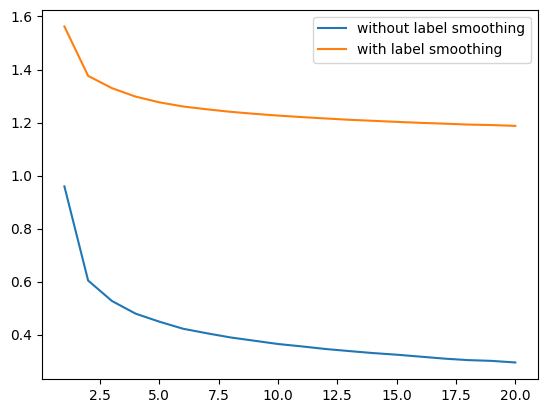

In [8]:
epochs = range(1, num_epoches+1)

plt.plot(epochs, train_losses_no_smoothing, label=('without label smoothing'))
plt.plot(epochs, train_losses_with_smoothing, label=('with label smoothing'))
plt.legend()
plt.show()